# [Modeling] Spatial Contexts for Los Angeles

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib import rcParams
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline
plt.style.use('fivethirtyeight')

## Predictive Modeling

Here we will use of CalEPA data for Los Angeles to draw inference and predictions using various models, including unsupervised and supervised models.

In [2]:
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0).dropna()
ces_la["CES 4.0 Percentile Range"] = ces_la['CES 4.0 Percentile Range'].replace("1-5% (lowest scores)", "00-05%").replace("5-10%", "05-10%").replace("95-100% (highest scores)", "95-100%")

In [3]:
ces_la

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,CES 4.0 Percentile,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100%,0.048,...,99.97,13.34,72.59,14.07,97.27,1.71,0.84,0.00,0.00,0.18
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100%,0.042,...,99.91,18.60,72.48,8.92,78.14,1.09,15.67,0.00,4.84,0.25
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100%,0.049,...,99.87,7.70,84.50,7.80,75.55,2.85,10.45,0.00,6.95,4.20
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100%,0.041,...,99.86,12.77,73.16,14.07,69.34,3.98,8.43,0.00,16.32,1.92
5,6037433501,1949,Los Angeles,91733,South El Monte,-118.065122,34.057255,76.91,95-100%,0.055,...,99.85,10.98,75.42,13.60,93.89,0.72,0.00,0.00,5.39,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,6037262604,5523,Los Angeles,90272,Los Angeles,-118.548578,34.051108,3.85,00-05%,0.051,...,1.31,14.01,58.34,27.65,3.31,86.24,0.00,0.00,5.63,4.82
2056,6037670702,5649,Los Angeles,90275,Rancho Palos Verdes,-118.328443,33.753600,3.53,00-05%,0.039,...,1.02,7.97,65.59,26.45,8.43,68.53,1.12,0.42,15.29,6.21
2057,6037620904,2897,Los Angeles,90266,Manhattan Beach,-118.410369,33.880731,3.08,00-05%,0.043,...,0.72,12.60,70.80,16.60,4.42,85.71,0.00,0.00,2.35,7.53
2058,6037262802,3424,Los Angeles,90272,Los Angeles,-118.502456,34.045865,2.23,00-05%,0.050,...,0.34,11.42,61.89,26.69,10.72,80.96,0.32,0.00,2.98,5.02


In [4]:
# Columns to be dropped

identifiers = ['Census Tract', 'Total Population', 'California County', 'ZIP', 'Approximate Location', 'Longitude', 'Latitude', 'CES 4.0 Score', 'CES 4.0 Percentile Range', 'CES 4.0 Percentile']
pctl = list(ces_la.filter(regex = 'Pctl'))

## 1. Unsupervised Modeling

Without telling our models about the CES 4.0 Scores nor corresponding Percentile groups, can they learn about them? 

Can we use specific features to predict a score, population characteristic, or pollution indicator?

### Principal Component Analysis

Why PCA? We are:

1. Visually identifying clusters of similar observations in high dimensions.
2. We have reason to believe that the data are inherently low rank: there are many attributes, but only a few  attributes mostly determine the rest through a linear association.

Are there features we should be aware of that guide our understanding of the CES 4.0 Scores? Whether linear or non-linear?


In [5]:
from sklearn.decomposition import PCA

In [6]:
# Transform data --> standardize for same standard deviation across all features

df_pca = ces_la.drop(columns=identifiers).drop(columns=pctl)
df_cols = list(df_pca.columns)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)
df_pca = pd.DataFrame(df_scaled)
df_pca = df_pca.set_axis(df_cols, axis=1)

In [7]:
# PCA

pca_vals = PCA(n_components=2).fit_transform(df_pca)
pca_df = pd.DataFrame(pca_vals, columns=['x','y'])

pca_df['CES 4.0 Percentile Range'] = ces_la['CES 4.0 Percentile Range'].to_numpy()

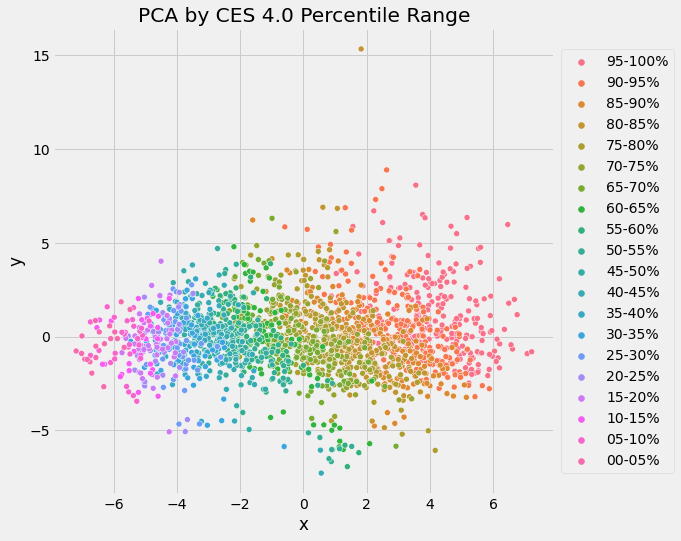

In [20]:
# Visualization

rcParams['figure.figsize'] = 8,8

sns.scatterplot(data=pca_df, x='x', y='y', hue='CES 4.0 Percentile Range')
plt.title('PCA by CES 4.0 Percentile Range')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


From this, we learn that our data does inheriently cluster in a 2D space for each of the CES 4.0 Percentile Ranges.

How much information do we lose? There are different ways to determine it. One of such was is a Scree Plot, but it is met with criticism based on the form of standardization performed [(source)](https://en.wikipedia.org/wiki/Scree_plot).

Next, is it possible to get similar results just using population characteristic data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [9]:
df_pop_pca = df_pca.iloc[:, 15:]

In [10]:
# PCA

pca_pop_vals = PCA(n_components=2).fit_transform(df_pop_pca)
pca_pop_df = pd.DataFrame(pca_pop_vals, columns=['x','y'])

pca_pop_df['CES 4.0 Percentile Range'] = ces_la['CES 4.0 Percentile Range'].to_numpy()

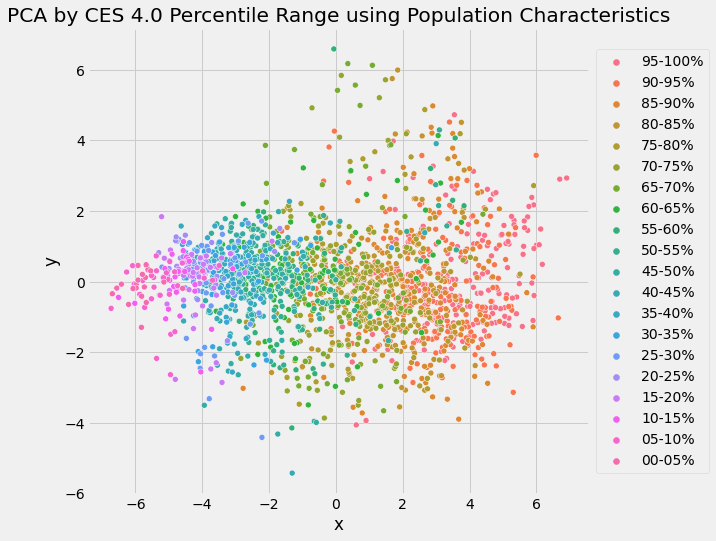

In [19]:
# Visualization

rcParams['figure.figsize'] = 8,8

sns.scatterplot(data=pca_pop_df, x='x', y='y', hue='CES 4.0 Percentile Range')
plt.title('PCA by CES 4.0 Percentile Range using Population Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Yes! It seems like PCA is able to achieve similar results just using population characteristics, including the following features:

In [16]:
df_pop_pca.columns

Index(['Asthma', 'Low Birth Weight', 'Cardiovascular Disease', 'Education',
       'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden',
       'Pop. Char. ', 'Pop. Char. Score', 'Children < 10 years (%)',
       'Pop 10-64 years (%)', 'Elderly > 64 years (%)', 'Hispanic (%)',
       'White (%)', 'African American (%)', 'Native American (%)',
       'Asian American (%)', 'Other/Multiple (%)'],
      dtype='object')

### Clustering

We will use affinity propogation as we are working with many clusters of unequal size.

In [12]:
from sklearn.cluster import AffinityPropagation

In [13]:
df_cluster = ces_la.drop(columns=identifiers).drop(columns=pctl)
df_cluster_cols = list(df_cluster.columns)

In [14]:
df_cluster

,Ozone,PM2.5,Diesel PM,Drinking Water,Lead,Pesticides,Tox. Release,Traffic,Cleanup Sites,Groundwater Threats,...,Pop. Char. Score,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,0.048,12.251640,0.781,787.94,92.56,0.00,3682.693278,2522.622269,38.75,20.50,...,8.69,13.34,72.59,14.07,97.27,1.71,0.84,0.00,0.00,0.18
2,0.042,12.216660,0.376,459.20,91.35,1.66,14883.206710,1575.354550,22.50,63.50,...,8.86,18.60,72.48,8.92,78.14,1.09,15.67,0.00,4.84,0.25
3,0.049,12.576875,1.053,798.87,74.68,0.00,1894.993347,2125.866346,16.80,47.55,...,8.51,7.70,84.50,7.80,75.55,2.85,10.45,0.00,6.95,4.20
4,0.041,12.066061,0.637,805.57,66.07,66.50,19774.789710,3455.239256,16.00,37.55,...,7.73,12.77,73.16,14.07,69.34,3.98,8.43,0.00,16.32,1.92
5,0.055,12.004168,0.551,821.08,91.11,0.01,2234.535319,905.045862,19.60,198.65,...,8.66,10.98,75.42,13.60,93.89,0.72,0.00,0.00,5.39,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,0.051,11.249036,0.068,439.39,40.31,0.00,1165.687327,947.854365,20.00,15.00,...,0.68,14.01,58.34,27.65,3.31,86.24,0.00,0.00,5.63,4.82
2056,0.039,11.404007,0.019,277.20,41.13,0.00,4849.723307,660.129535,2.00,1.00,...,0.92,7.97,65.59,26.45,8.43,68.53,1.12,0.42,15.29,6.21
2057,0.043,11.879107,0.073,237.39,39.36,0.00,5004.616699,489.438537,0.80,0.00,...,0.89,12.60,70.80,16.60,4.42,85.71,0.00,0.00,2.35,7.53
2058,0.050,11.339568,0.104,540.97,48.87,0.03,1346.864665,1056.156142,0.00,0.00,...,0.46,11.42,61.89,26.69,10.72,80.96,0.32,0.00,2.98,5.02


In [15]:
clustering = AffinityPropagation(random_state=5).fit(df_clustering[['CES 4.0 Score', 'White (%)']])

NameError: name 'df_clustering' is not defined

What can we learn?

## 2. Supervised Modeling

### Classification

### Regression